In [4]:
from analysis import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from scipy.interpolate import make_interp_spline
import seaborn as sns
from matplotlib import rc

rc('text', usetex=False)
rc('font', family='sans-serif')

In [5]:
param_set = [[0.05, 241], [0.1143, 199], [0.1786, 159], [0.2429, 123], 
           [0.3071, 89], [0.3714, 66], [0.4357, 58], [0.5, 58]]# np.array([[0.05, 80], [0.1143, 56], [0.1786, 41], 
                   # [0.2429, 32], [0.3071, 29], [0.3714, 25], [0.4357, 24], [0.5, 24]])
eps_levels = [i for (i,j) in param_set]
eps_thresh = [j for (i,j) in param_set]
data_path = "arm3_eps_v2/data"
files, N = get_files_in_directory(data_path)
print("\n\n")
show_bonuses(files, eps_thresh)

There are 53 subject's data files in this folder.



The following participants received a bonus. Results are displayed in the format id,bonus:

60f275aeeae99d547a89f5b8,1.0
611d05c997db7c2653864ff4,1.48
60b7e28349c6c6d290dc8075,1.09
6310a2fb7a4dd7e9a7e72dea,1.23
5ece064a75736a193990951a,1.53
60832513ad492f85d73a0574,1.32
5f632ea32e85353d93872c67,1.07
60194185dc1e1f00083cb6c6,1.57
60ffd7de4dc3ea2bfd477a22,1.4
5f3d7b3310ad88134a27f2c7,1.67
5f3d718e8de6ae12265b95ae,1.16
5cd1bdedf2156c00013b0152,1.37
5ec3f25d9cedf7287004cd26,1.03
61648e4f0d2212047ab36b27,1.64
606c6e9f7e86c0264ab3d7d8,1.51
64528908f63d6e6beb01b877,1.39


# Overall summary of participant population

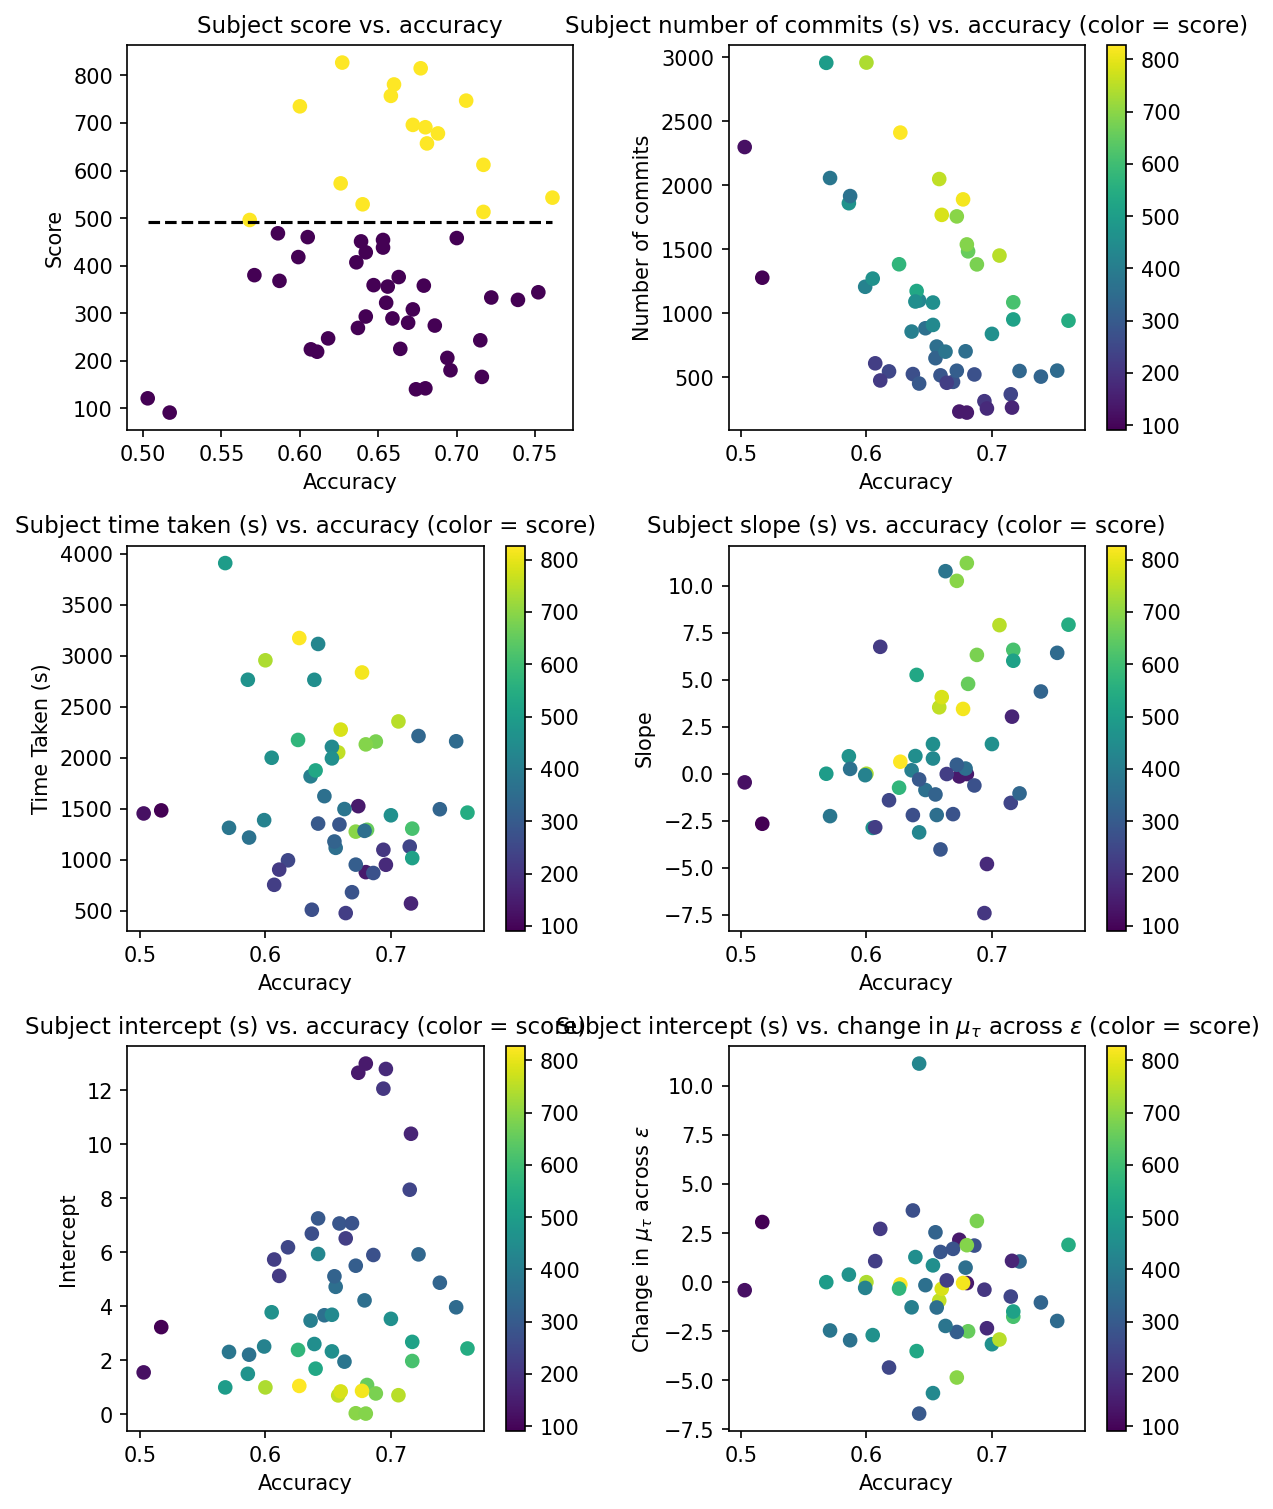

In [6]:
summary = get_population_summary(files, eps_thresh)

### Comments


# theoretical predictions

In [4]:
path = '../model/sims/'
df_eps = pd.read_csv(path+'eps_simulate_1000_q0.75_2023-07-28.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(7,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
x,y = np.array(df_eps['eps']).reshape(-1,1), np.array(df_eps['mu_i']).reshape(-1,1)
plt.scatter(x,y)
fit_eps, fit_mu, __, __ = get_linear_fit(x,y)
plt.plot(fit_eps, fit_mu, 'k--')
plt.xlabel('$\epsilon$')
plt.ylabel('$\mu_\\tau$ (mean commitment time)')
plt.title('Model predictions for mean commitment time as a function of $\epsilon$')

In [5]:
mdl_avg_eps = []
for e in df_eps['eps'].unique():
    eps_level = df_eps[df_eps['eps'] == e]['mu_i']
    mdl_avg_eps.append(np.mean(eps_level))
fig, ax = plt.subplots(figsize=(7,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
plt.plot(df_eps['eps'].unique(), mdl_avg_eps, c='black', linewidth=5)

# comparison before and after discarding first 70 trials

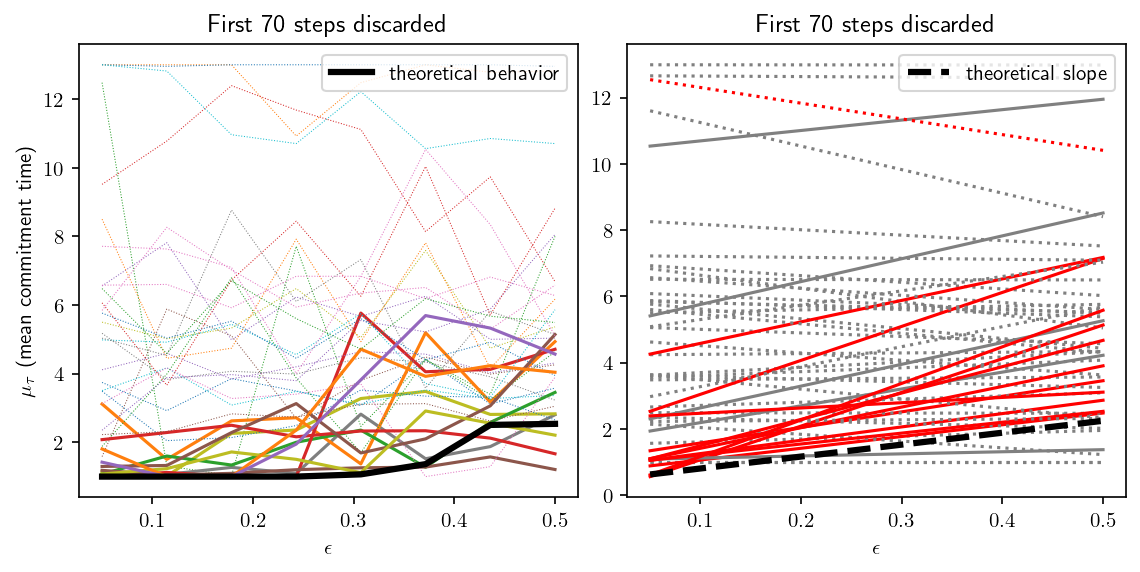

In [41]:
fig, ax = plt.subplots(figsize=(9,4),dpi=150)
plt.subplots_adjust(wspace=0.1)
plt.subplot(122)
pop_acc = []
discard = 70
for f in files:
    pid, df, acc, length = load(f, eps_thresh)
    pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
for f in files:
    pid, df, acc, length = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < 2*np.std(pop_acc):
        __, eps, mu_i, __ = get_mean_iai(df, discard)
        x,y,l,c = get_linear_fit(eps,mu_i)
#         plt.scatter(np.linspace(1,8,8),mu_i)
        plt.plot(x,y, linestyle = l, c=c)
plt.xlabel('$\epsilon$')
plt.plot(fit_eps, fit_mu, 'k--', linewidth = 3, label = "theoretical slope")
plt.title("First 70 steps discarded")
plt.legend()


plt.subplot(121)
discard = 70
pop_acc = []
for f in files:
    pid, df, acc, length = load(f, eps_thresh)
    pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
for f in files:
    pid, df, acc, length = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < np.std(pop_acc):
        __, eps, mu_i, __ = get_mean_iai(df, discard)
        xy = np.concatenate((eps[:,0].reshape(-1,1), mu_i[:,0].reshape(-1,1)), axis=1)
        xy = pd.DataFrame(xy, columns = ["x", "y"])
        xy = xy.sort_values('x')
        if compute_bonus(df, eps_thresh) == 0:
            plt.plot(np.array(xy["x"]), np.array(xy["y"]), linestyle = 'dotted', linewidth=0.5)
        else:
            plt.plot(np.array(xy["x"]), np.array(xy["y"]))
        x,y,l,c = get_linear_fit(eps,mu_i)
plt.plot(df_eps['eps'].unique(), mdl_avg_eps, c='black', linewidth=3, label = 'theoretical behavior')
plt.xlabel('$\epsilon$')
plt.title("First 70 steps discarded")
plt.ylabel('$\mu_\\tau$ (mean commitment time)')
plt.legend()

Text(0.5, 1.0, 'Accuracy across blocks for arm3\\_eps')

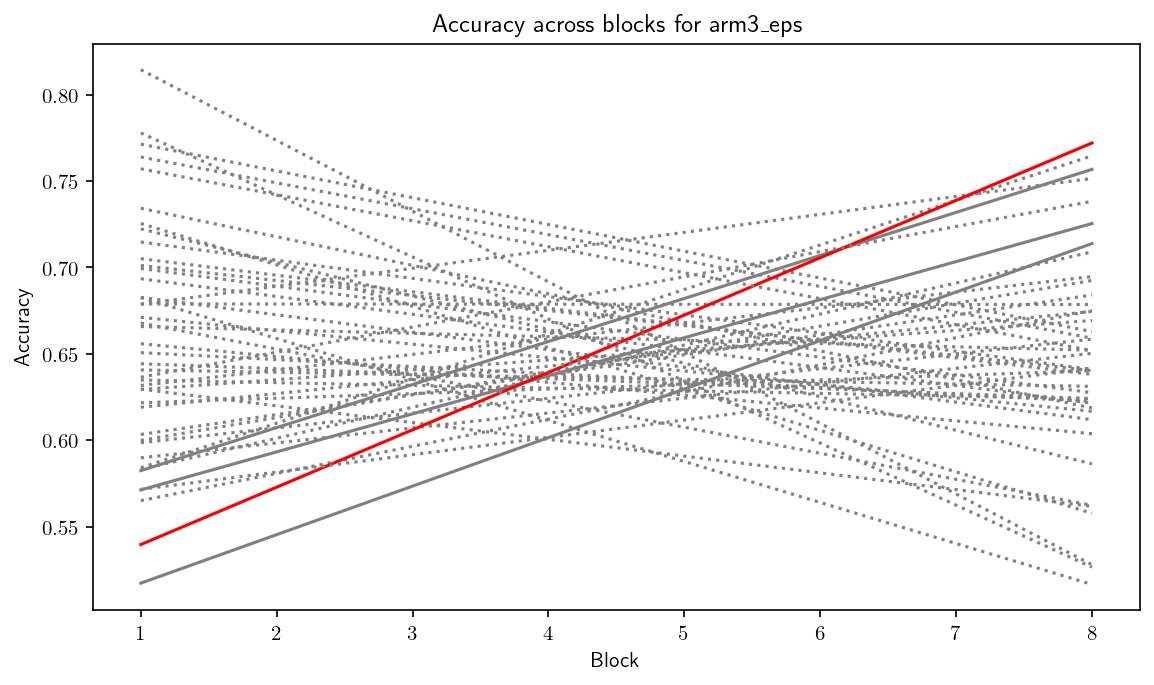

In [45]:
fig, ax = plt.subplots(figsize=(9,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
for f in files:
    pid, df, acc, length = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < 1.25*np.std(pop_acc):
        __, eps, acc_i = get_accuracy(df)
        rounds = np.linspace(1,8,8).reshape(-1,1)
        x,y,l,c = get_linear_fit(rounds,acc_i)
        plt.plot(x,y, linestyle = l, c=c)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy across blocks for arm3\_eps')
# plt.plot(fit_q, fit_mu, 'k--')

Text(0.5, 1.0, 'Accuracy across blocks for arm3_q')

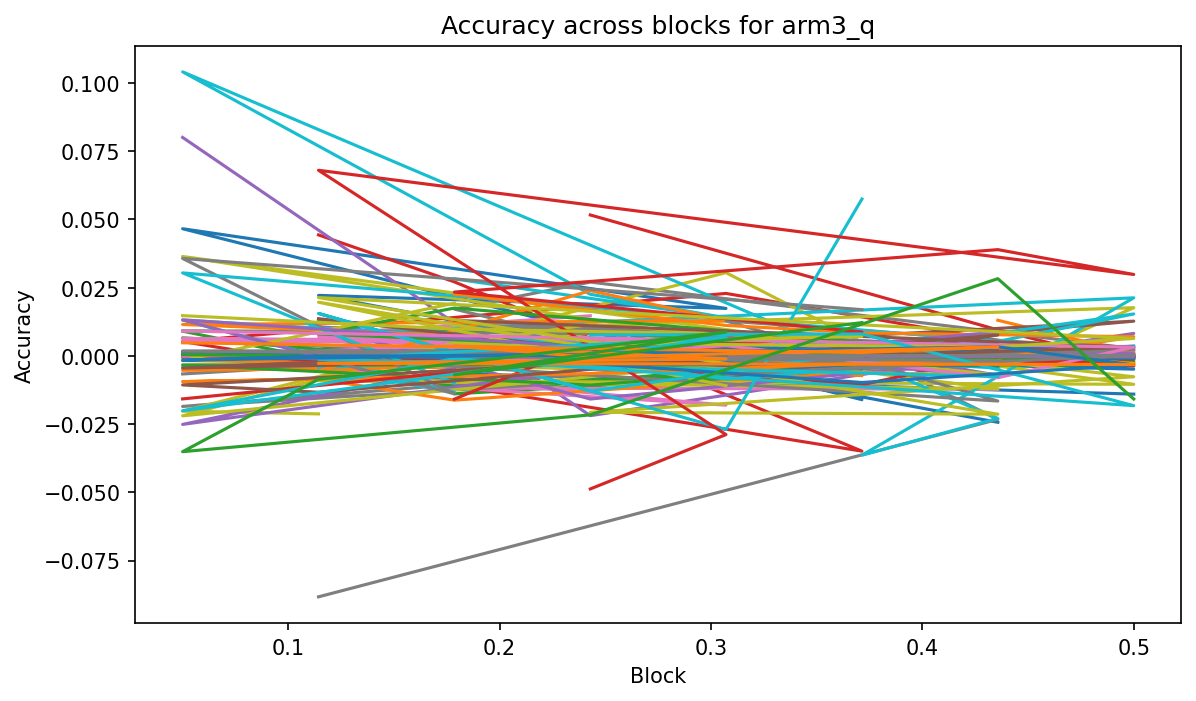

In [10]:
fig, ax = plt.subplots(figsize=(9,5),dpi=150)
plt.subplots_adjust(wspace=0.2)
belief = []
for f in files:
    pid, df, acc, length = load(f, eps_thresh)
    q, eps, thr = get_abs_threshold(df)
    belief.append(thr)
    plt.plot(eps, thr)
#     plt.plot(down_price)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy across blocks for arm3_q')
# plt.plot(fit_q, fit_mu, 'k--')

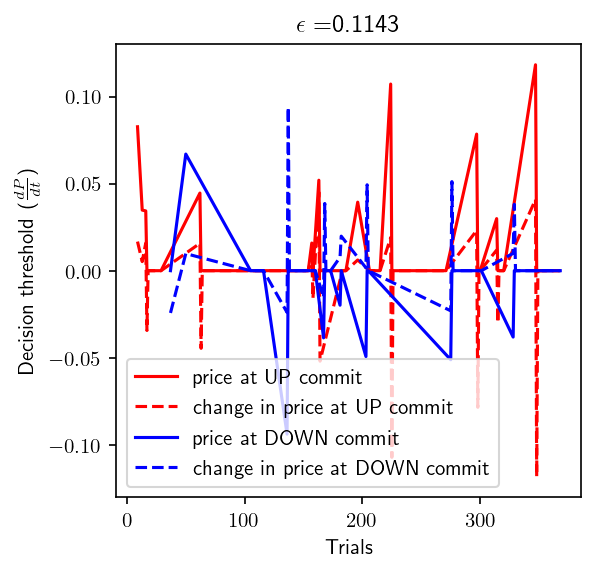

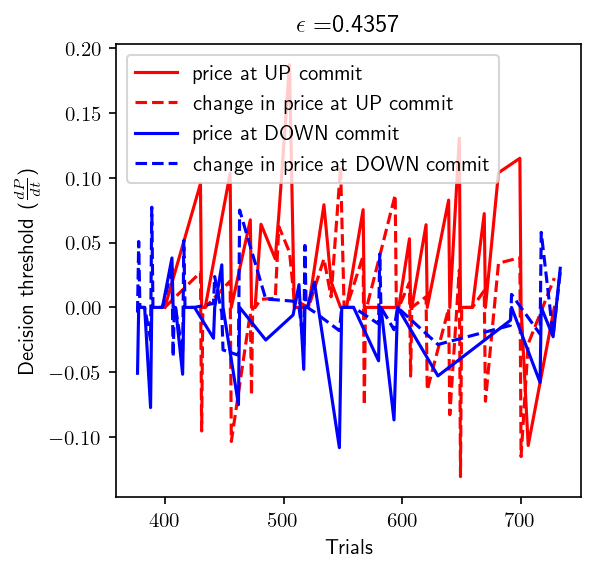

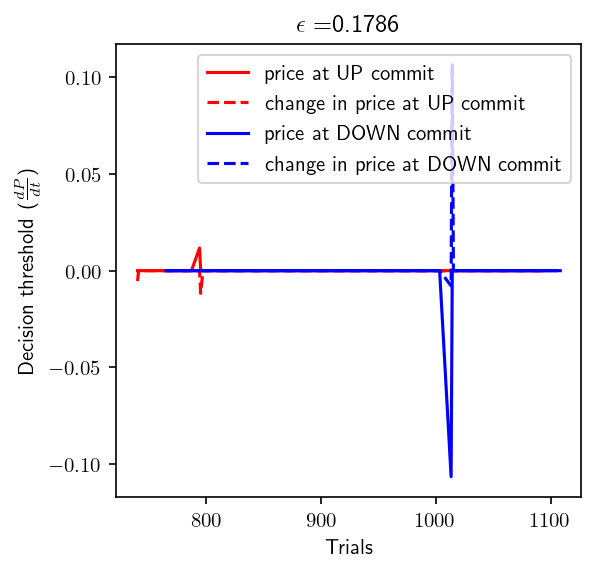

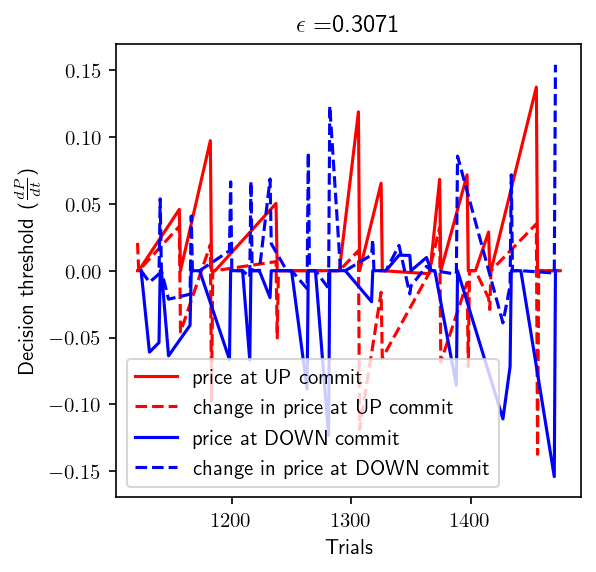

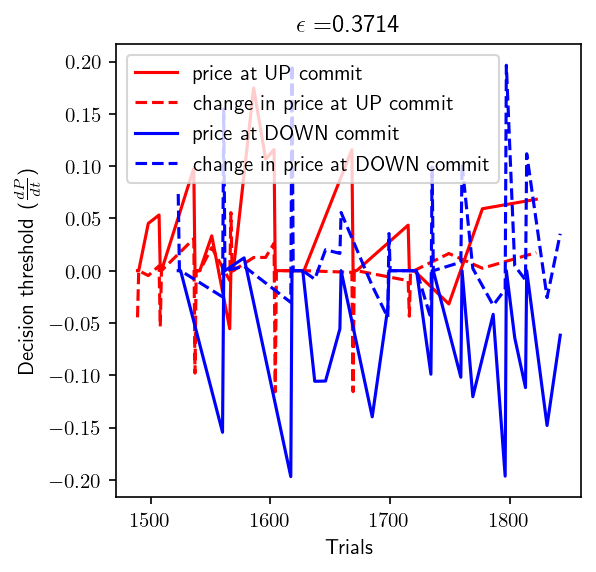

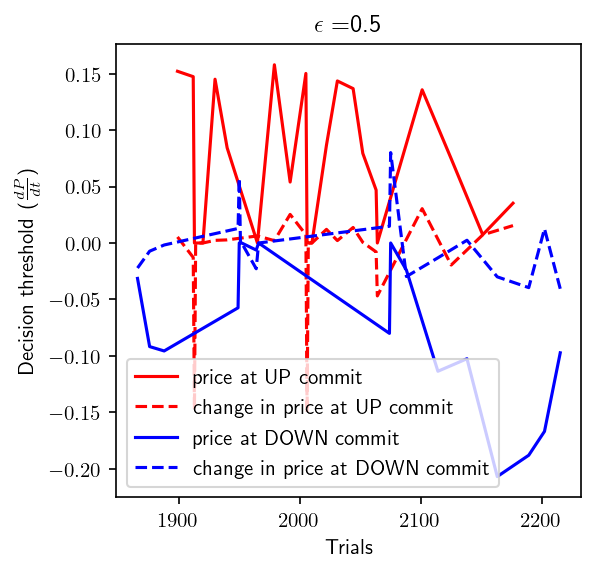

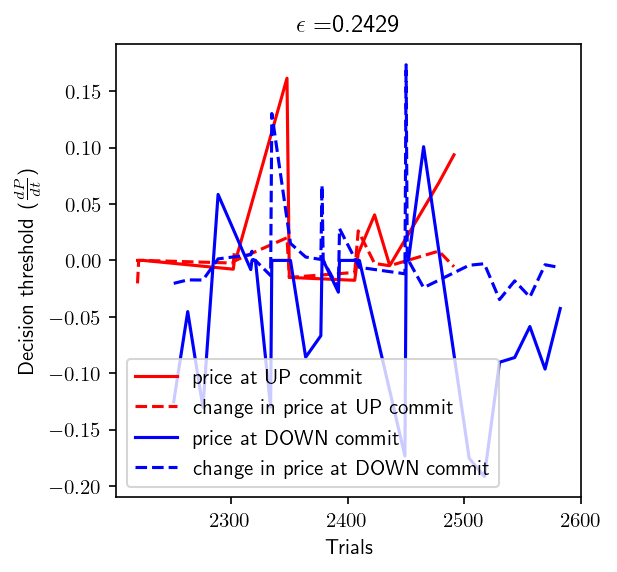

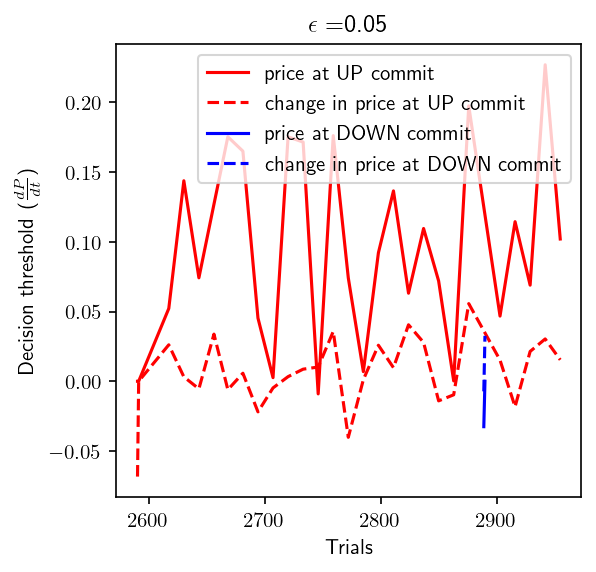

In [14]:
for i in range(1,numBlocks+1):
    fig, ax = plt.subplots(figsize=(4,4),dpi=150)
    curBlock = block(i,df, 0)
    ups = curBlock.index[curBlock['resp.keys'] == 1]
    ups = ups - 1
    ups = ups[1:]
    downs = curBlock.index[curBlock['resp.keys'] == -1]
    downs = downs - 1
    downs = downs[1:]
    both = curBlock.index[np.abs(curBlock['resp.keys']) == 1]
    both = both - 1
    both = both[1:]
    plt.plot(df.iloc[ups]['price'], 'r', label = 'price at UP commit')
    plt.plot(df.iloc[ups]['dPrice_dt'], 'r--', label = 'change in price at UP commit')
    plt.plot(df.iloc[downs]['price'], 'b', label = 'price at DOWN commit')
    plt.plot(df.iloc[downs]['dPrice_dt'], 'b--', label = 'change in price at DOWN commit')
    plt.xlabel('Trials')
    plt.ylabel('Decision threshold ($\\frac{dP}{dt}$)')
    plt.title('$\epsilon = $' + str(curBlock['eps_prob'].iloc[0]))
    plt.legend()
    plt.show()

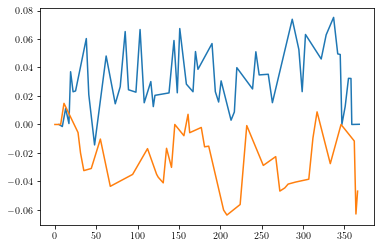

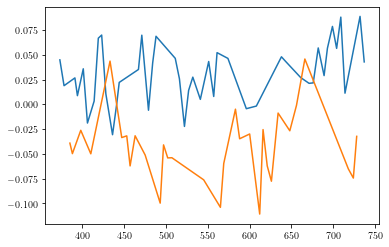

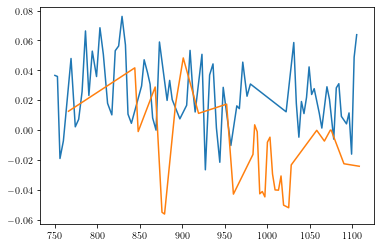

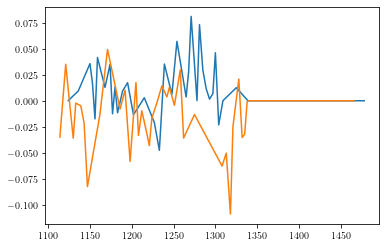

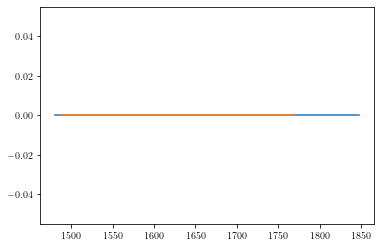

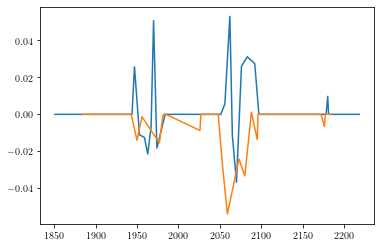

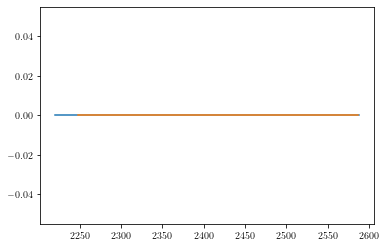

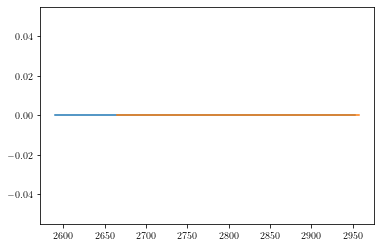

In [38]:
for i in range(1,numBlocks+1):
    curBlock = block(i,df, 0)
    ups = curBlock.index[curBlock['resp.keys'] == 1]
    ups = ups - 1
    ups = ups[1:]
    downs = curBlock.index[curBlock['resp.keys'] == -1]
    downs = downs - 1
    downs = downs[1:]
    plt.plot(df.iloc[ups]['price'])
    plt.plot(df.iloc[downs]['price'])
    plt.show()

In [40]:
np.sum(df['resp.rt'])

418.7741

In [11]:
df

,resp.keys,state,q_prob,eps_prob,score,price,resp.rt,steps.thisN,commit,dPrice_dt
0,0,1.0,0.75,0.3714,0.0,0.003425,0.2670,0.0,0,0.003425
1,0,1.0,0.75,0.3714,0.0,0.014503,0.1336,1.0,0,0.011077
2,0,1.0,0.75,0.3714,0.0,0.044127,0.1387,2.0,0,0.029625
3,0,1.0,0.75,0.3714,0.0,0.064935,0.1167,3.0,0,0.020808
4,0,1.0,0.75,0.3714,0.0,0.066134,0.1190,4.0,0,0.001199
...,...,...,...,...,...,...,...,...,...,...
2955,-1,1.0,0.75,0.5000,225.0,0.000000,0.1499,365.0,1,0.056217
2956,0,1.0,0.75,0.5000,225.0,0.003417,0.0005,366.0,0,0.003417
2957,0,1.0,0.75,0.5000,225.0,0.022288,0.1669,367.0,0,0.018871
2958,0,1.0,0.75,0.5000,225.0,0.068810,0.1834,368.0,0,0.046521


In [15]:
len(df[df['commit'] == 1])

458